In [1]:
import numpy as np
import mxnet as mx
from mxnet import gluon
ctx = mx.gpu(0)

In [2]:
import matplotlib.pyplot as plt

# Dilated convolution for Conditional PixelCNN
Autoregressive models based on convolutional layers are restricted to refer just nearby pixels when predicting a value of new pixel. To enlarge the area where context is taken into account, WaveNet \[[arxiv:1609.03499](https://arxiv.org/pdf/1609.03499.pdf)\] uses dilated convolution. As such, the network can model relatively long-scale context of the sequential data.

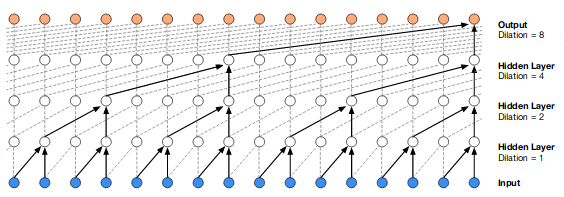
$$ \mathrm{Dilated\ convolution\ of\ WaveNet} $$

With the dilation technique, the conditional PixelCNN is expected to be aware wider area and generate more consistent output.

In [3]:
class VStack(gluon.nn.Conv2D):
    '''Vertical stack of a PixelCNN layer
    
    Gluon's 2D-convolution layer modified as to capture the image context
    descending from top line to target line.
    When kernel_type is set to 'A'(default), the convolution does not rely on
    the value of same position of previous layer, which preserves *causality*.
    '''
    def __init__(self, channels, kernel_size, strides=(1, 1),
                 dilation=(1, 1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', **kwargs):
        pad_h = (kernel_size[0]-1)*dilation[0] + 1 * ('A' is kernel_type)
        pad_w = (kernel_size[1]//2)*dilation[1]
        super(VStack, self).__init__(channels, kernel_size, strides,
                 (pad_h, pad_w), dilation, groups, layout,
                 activation, use_bias, weight_initializer,
                 bias_initializer, in_channels, **kwargs)

    def hybrid_forward(self, F, x, weight, bias=None):
        act = super(VStack, self).hybrid_forward(F, x, weight, bias)
        return F.slice_like(act, x, axes=[2,3])

class HStack(gluon.nn.Conv2D):
    '''Horizontal stack of a PixelCNN layer
    
    Gluon's 2D-convolution layer modified as to capture the image context
    propagating from left pixel to right pixel.
    When kernel_type is set to 'A'(default), the convolution does not rely on
    the value of same position of previous layer, which preserves *causality*.
    '''
    def __init__(self, channels, kernel_len, strides=(1, 1),
                 dilation=(1,1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', **kwargs):
        pad_w = (kernel_len-1)*dilation[1] + 1 * ('A' is kernel_type)
        super(HStack, self).__init__(channels, (1,kernel_len), strides,
                 (1, pad_w), dilation, groups, layout,
                 activation, use_bias, weight_initializer,
                 bias_initializer, in_channels, **kwargs)

    def hybrid_forward(self, F, x, weight, bias=None):
        act = super(HStack, self).hybrid_forward(F, x, weight, bias)
        return F.slice_like(act, x, axes=[2,3])
    
class GatedLayer(gluon.HybridBlock):
    '''Implementation of a single layer in Gated PixelCNN (A. van den Oord, et.al., NIPS2016 6527)
    '''
    def __init__(self, channels, kernel_size, strides=(1, 1),
                 dilation=(1, 1), groups=1, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', residual=True, **kwargs):
        super(GatedLayer, self).__init__(**kwargs)
        self.channels = channels
        self.residual = residual
        with self.name_scope():
            self.vstack = VStack(channels*2, kernel_size, strides,
                 (dilation[0], 1), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, in_channels, kernel_type, **kwargs)
            self.hstack = HStack(channels*2, kernel_size[1], strides,
                 (1, dilation[1]), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, in_channels, kernel_type, **kwargs)
            self.vtoh = gluon.nn.Conv2D(channels*2, (1,1), strides,
                 (0,0), (1,1), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, channels*2, **kwargs)
            self.htoh = gluon.nn.Conv2D(channels, (1,1), strides,
                 (0,0), (1,1), groups, 'NCHW', None, use_bias, weight_initializer,
                 bias_initializer, channels, **kwargs)
            
    def hybrid_forward(self, F, x):
        vx, hx = F.split(x, axis=1, num_outputs=2)
        vstack = self.vstack(vx)
        hstack = self.hstack(hx) + self.vtoh(vstack)
        
        vstack_presig, vstack_pretanh = F.split(vstack, axis=1, num_outputs=2)
        hstack_presig, hstack_pretanh = F.split(hstack, axis=1, num_outputs=2)
        vstack_out = F.sigmoid(vstack_presig) * F.tanh(vstack_pretanh)
        hstack_preres = self.htoh(F.sigmoid(hstack_presig) * F.tanh(hstack_pretanh))
        # residual connection for hstack
        if not self.residual:
            hstack_out = hstack_preres
        elif hx.shape[1] < self.channels:
            zpad_shape = list(hx.shape)
            zpad_shape[1] = self.channels - zpad_shape[1]
            hstack_out = hstack_preres + F.concat(hx, F.zeros(zpad_shape), dim=1)
        else:
            hstack_out = hstack_preres + hx
            
        return mx.nd.concat(vstack_out, hstack_out, dim=1)

In [4]:
class ConditionalLayer(GatedLayer):
    def __init__(self, channels, kernel_size, strides=(1, 1),
                 dilation=(1, 1), groups=1, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, kernel_type='A', residual=True, **kwargs):
        super(ConditionalLayer, self).__init__(channels, kernel_size, strides,
                 dilation, groups, use_bias, weight_initializer,
                 bias_initializer, in_channels, kernel_type, residual, **kwargs)
        with self.name_scope():
            self.embedder = gluon.nn.Conv2D(channels*4, (1,1))
            
    def hybrid_forward(self, F, x, h):
        for _ in range(2):
            h = F.expand_dims(h, axis=-1)
        vstack_presig_cond, vstack_pretanh_cond, hstack_presig_cond, hstack_pretanh_cond = \
            F.split(self.embedder(h), axis=1, num_outputs=4)
        
        vx, hx = F.split(x, axis=1, num_outputs=2)
        vstack = self.vstack(vx)
        hstack = self.hstack(hx) + self.vtoh(vstack)
        
        vstack_presig, vstack_pretanh = F.split(vstack, axis=1, num_outputs=2)
        hstack_presig, hstack_pretanh = F.split(hstack, axis=1, num_outputs=2)
        vstack_out = F.sigmoid(vstack_presig + vstack_presig_cond) * F.tanh(vstack_pretanh + vstack_pretanh_cond)
        hstack_preres = self.htoh(F.sigmoid(hstack_presig + hstack_presig_cond) * F.tanh(hstack_pretanh + hstack_pretanh_cond))
        # residual connection for hstack
        if not self.residual:
            hstack_out = hstack_preres
        elif hx.shape[1] < self.channels:
            zpad_shape = list(hx.shape)
            zpad_shape[1] = self.channels - zpad_shape[1]
            hstack_out = hstack_preres + F.concat(hx, F.zeros(zpad_shape), dim=1)
        else:
            hstack_out = hstack_preres + hx
            
        return mx.nd.concat(vstack_out, hstack_out, dim=1)
    
class ConditionalSequential(gluon.nn.HybridSequential):
    def __init__(self, **kwargs):
        super(ConditionalSequential, self).__init__(**kwargs)
        
    def hybrid_forward(self, F, x, h):
        for block in self._children.values():
            x = block(x, h)
        return x, h
    
class ConditionalPixelCNN(gluon.nn.HybridBlock):
    def __init__(self, **kwargs):
        super(ConditionalPixelCNN, self).__init__(**kwargs)
        net1 = ConditionalSequential()
        net2 = gluon.nn.HybridSequential()
        with self.name_scope():
            net1.add(ConditionalLayer(16, (5,5), kernel_type='A', residual=False))
            net1.add(ConditionalLayer(16, (5,5), dilation=(1,1), kernel_type='B', residual=False))
            net1.add(ConditionalLayer(16, (5,5), dilation=(2,1), kernel_type='B', residual=False))
            net1.add(ConditionalLayer(16, (5,5), dilation=(4,1), kernel_type='B', residual=False))
            net2.add(GatedLayer(16, (5,5), dilation=(1,1), kernel_type='B', residual=False))
            net2.add(GatedLayer(16, (5,5), dilation=(1,1), kernel_type='B', residual=False))
            net2.add(gluon.nn.Conv2D(1, (1,1), activation='relu'))
        self.net1 = net1
        self.net2 = net2
            
    def hybrid_forward(self, F, x, h):
        x = F.tile(x, [1,2,1,1])
        x, _ = self.net1(x, h)
        return self.net2(x)

## Construction of the entine network

Residual connection is omitted because it seemed degrading the quality of output images.

In [5]:
net = ConditionalPixelCNN()
net.initialize(ctx=ctx)

## Data preparation

In [6]:
train_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32), y)), batch_size=24)
test_loader = gluon.data.DataLoader(
    gluon.data.vision.MNIST('.', train=False, transform=lambda x,y: (mx.nd.transpose(x, [2,0,1]).astype(np.float32), y)), batch_size=24)

## Training

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

for _ in range(30):
    cumulative_loss = 0
    for x,y in train_loader:
        x = mx.nd.array(x, ctx=ctx)
        y = mx.nd.array(y, ctx=ctx)
        with mx.autograd.record():
            cond = mx.nd.one_hot(y, depth=10)
            h = net(x,cond)
            loss = mx.nd.sum((h - x)**2, axis=[1,2,3])
        loss.backward()
        trainer.step(24)
        cumulative_loss += mx.nd.mean(loss).asscalar()
    test_loss = 0
    for x, y in test_loader:
        x = mx.nd.array(x, ctx=ctx)
        y = mx.nd.array(y, ctx=ctx)
        cond = mx.nd.one_hot(y, depth=10)
        h = net(x, cond)
        test_loss += mx.nd.mean(mx.nd.sum((h - x)**2, axis=[1,2,3])).asscalar()
    print('training loss: %.2f, test loss: %.2f'%(cumulative_loss/len(train_loader), test_loss/len(test_loader)))

training loss: 1294091.96, test loss: 726075.14
training loss: 532066.42, test loss: 748445.37
training loss: 512952.24, test loss: 716197.27
training loss: 501033.49, test loss: 583300.34
training loss: 491468.25, test loss: 678552.08
training loss: 485389.03, test loss: 574276.62
training loss: 478458.28, test loss: 665976.96
training loss: 478665.85, test loss: 681455.02
training loss: 475491.67, test loss: 593564.66
training loss: 469478.30, test loss: 645025.04
training loss: 469785.80, test loss: 687960.18
training loss: 466937.34, test loss: 621148.13
training loss: 465580.18, test loss: 614686.83
training loss: 463552.69, test loss: 550659.15
training loss: 460203.52, test loss: 630666.10
training loss: 463249.93, test loss: 583233.87
training loss: 457788.98, test loss: 525475.25
training loss: 456011.76, test loss: 541979.24
training loss: 454344.21, test loss: 564983.57
training loss: 453483.99, test loss: 514895.35
training loss: 453024.85, test loss: 602587.30
training los

## Image completion

In [8]:
for n, (x, y) in enumerate(test_loader):
    x = mx.nd.array(x, ctx=ctx)
    y = mx.nd.array(y, ctx=ctx)
    reconst =mx.nd.array(x, ctx=ctx)

for i in range(14,28):
    for j in range(28):
        cond = mx.nd.one_hot(y, depth=10)
        h = net(reconst,cond)
        reconst[:,:,i,j] = h[:,:,i,j]

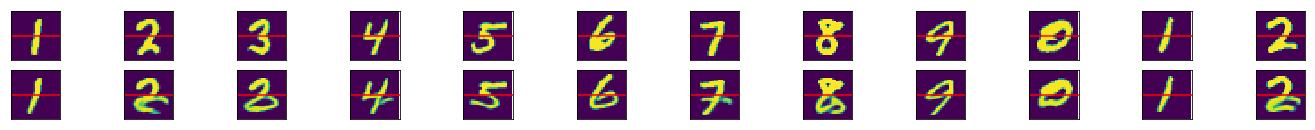

In [9]:
fig, ax = plt.subplots(2,12, figsize=(24,2))
for i in range(12):
    a1, a2 = ax[:, i]
    a1.set_xticks([])
    a2.set_xticks([])
    a1.imshow(x.asnumpy()[i,0,:,:])
    a1.plot([0,28], [14,14], 'r')
    a2.imshow(reconst.asnumpy()[i,0,:,:])
    a2.plot([0,28], [14,14], 'r')
    a1.set_xticks([])
    a2.set_xticks([])
    a1.set_xlim([0,28])
    a2.set_xlim([0,28])
    a1.set_yticks([])
    a2.set_yticks([])

1st row: Original images are taken from the test dataset.

2nd row: The lower half of the images (below the red line) are once removed, and estimated by the Conditional PixelCNN based on the information contained in upper half of the images.

## Image generation

In [10]:
y = mx.nd.arange(10, ctx=ctx)
gen =mx.nd.zeros_like(x[:10], ctx=ctx)

for i in range(28):
    for j in range(28):
        cond = mx.nd.one_hot(y, depth=10)
        h = net(gen,cond)
        gen[:,:,i,j] = h[:,:,i,j]

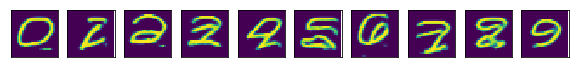

In [11]:
fig, ax = plt.subplots(1,10, figsize=(10,2))
for i,a in enumerate(ax):
    a.set_xticks([])
    a.imshow(gen.asnumpy()[i,0,:,:])
    a.set_xlim([0,28])
    a.set_yticks([])